In [8]:
from src import *

## Table of Contents
- [Frame selected emotion gradients](#comparison)

<a class="anchor" id="comparison"></a>
### Frame selected emotion gradients

Selecting snippets for timecourses according to emotion strength 

In [2]:
# We look at the same movie data but simply include subcortical in one of the sets
mri_path400 = "./data/fmri400_compiled/"

# obtained from data exploration
prop = {'W_AfterTheRain13.csv': ['Fear', 0.148],
 'W_BetweenViewing13.csv': ['WarmHeartedness', 0.172],
 'W_BigBuckBunny13.csv': ['Disgust', 0.234],
 'W_Chatter13.csv': ['Fear', 0.261],
 'W_FirstBite13.csv': ['Love', 0.201],
 'W_LessonLearned13.csv': ['Disgust', 0.203],
 'W_Payload13.csv': ['Disgust', 0.163],
 'W_Sintel13.csv': ['Anger', 0.241],
 'W_Spaceman13.csv': ['WarmHeartedness', 0.197],
 'W_Superhero13.csv': ['Fear', 0.16],
 'W_TearsOfSteel13.csv': ['Anxiety', 0.154],
 'W_TheSecretNumber13.csv': ['Fear', 0.142],
 'W_ToClaireFromSonny13.csv': ['Happiness', 0.141],
 'W_YouAgain13.csv': ['Guilt', 0.134]}


In [3]:
nb_frame = 100
selected_series = {}
for movie_name400 in tqdm(os.listdir(mri_path400)):
    if "Rest" in movie_name400: continue
    mri_df400mov    = pd.read_csv(mri_path400 + movie_name400)

    film_duration = FILM2DURATION[movie_name400.split('_')[0]] # in seconds
    duration_film = int(film_duration/ TR) # in number of TRs
    front_pad     = int(WASH + ONSET) + 1

    # Simply replace 400 by 414 to look at spatial relation with subcortical regions included
    movies = [m for m in mri_df400mov.filename.unique() if "400" in m] 
    movie_series = []
    for m in movies:
        tmp1, _ = df_to_timeseries(mri_df400mov, m)
        tmp1    = tmp1[front_pad :  front_pad + duration_film]
        movie_series.append(tmp1)
    movie_series = np.asarray(movie_series)

    absemo_df = pd.read_csv('./data/emotion_compileBIDS.csv')
    absemo_df = absemo_df[absemo_df['filename']=='W_{}13.csv'.format(movie_name400.split('_')[0])]

    # select from emotion timeseries frames with strong emotions
    dominant = prop['W_{}13.csv'.format(movie_name400.split('_')[0])][0]
    tmp          = np.array(absemo_df[absemo_df['item'] == dominant]['score'])[:-1]

    # top 50 frames most emotions
    # frame_select = np.argsort(np.abs(tmp - tmp.mean()))[-50:]
    frame_select = np.argsort(tmp)[-nb_frame:]
    selected_series[movie_name400.split('_')[0]] = np.concatenate(movie_series[:,frame_select])

rest_series  = []
mri_df400rest   = pd.read_csv(mri_path400 + "Rest_compiled.csv")
rests  = [m for m in mri_df400rest.filename.unique() if "400" in m]
for r in rests:
    tmp2, _ = df_to_timeseries(mri_df400rest, r)
    rest_series.append(tmp2)
rests_series  = np.concatenate(rest_series)

100%|████████████████████████████████████████████████████████████████| 15/15 [10:15<00:00, 41.05s/it]


In [4]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

fc_rests  = FC(rests_series)
g_rests  = GradientMaps(n_components=nb_comp, approach=embedding, 
                        kernel=aff_kernel, random_state=rs)
g_rests.fit(fc_rests)

samples_label  = ['Rest']
samples_grad   = [g_rests.gradients_]
for label in selected_series:

    try:
        fc_dominant = FC(selected_series[label])
        g  = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, alignment=align_meth,random_state=rs)
        g.fit(fc_dominant, reference=g_rests.gradients_)
    except:
        print(label)
        continue
    samples_grad.append(g.aligned_)
    samples_label.append(label)

Less than 10 timepoints for correlation
BetweenViewing


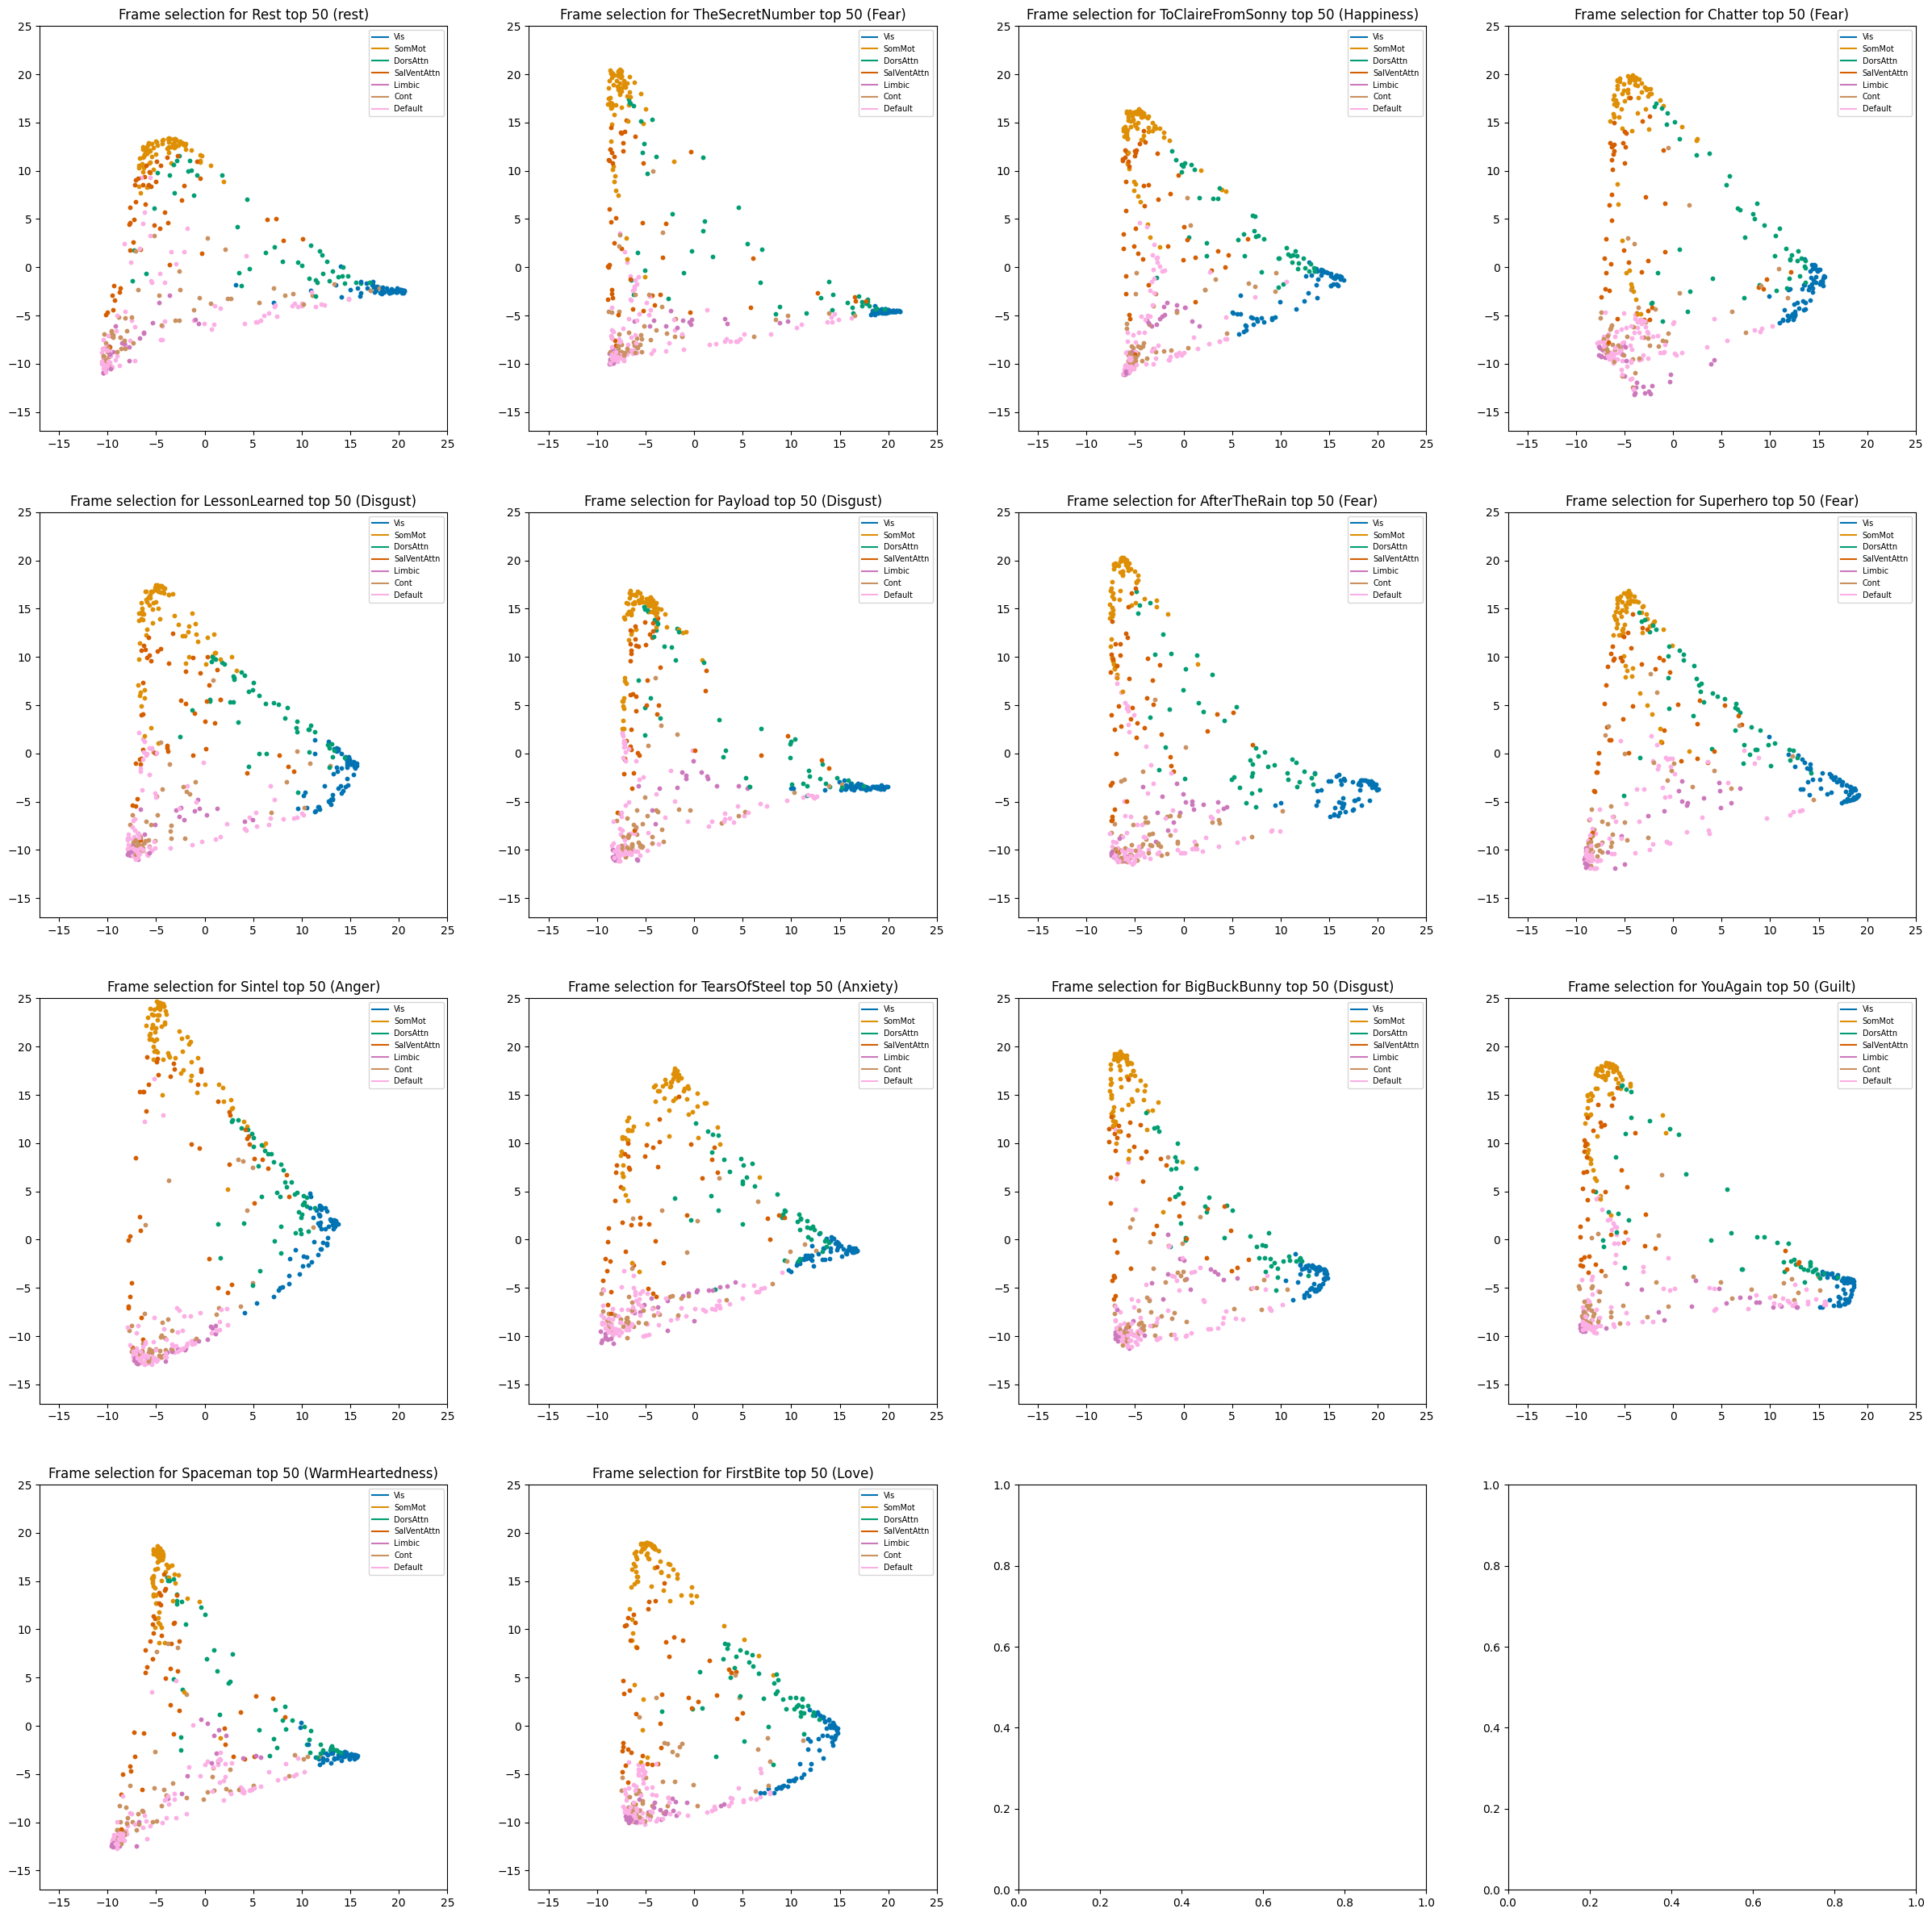

In [7]:
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)


partial_region = load('./resources/region400yeo7.pkl')
colors = {N: my_cmap.colors[idx] for idx, N in enumerate(list(index2region.keys()))}

fig, axes = plt.subplots(4,4, figsize=(30,30))
for k in range(len(samples_grad)):
    row,col = k//4, k%4

    for i in range(len(samples_grad[k])):
        c   = partial_region[i]
        axes[row,col].scatter([samples_grad[k][i,0]], [samples_grad[k][i,1]], s=10, facecolor=colors[c])

    if samples_label[k] == 'Rest':
        dominant = 'rest'
    else:
        dominant = prop['W_{}13.csv'.format(samples_label[k])][0]
    axes[row,col].set_title("Frame selection for {} top 50 ({})".format(samples_label[k], dominant), size=12)

    C       = list(colors.values())
    labels  = list(colors.keys())
    dummies = [axes[row,col].plot([], [], ls='-', c=c)[0] for c in C]
    axes[row,col].legend(dummies, labels, loc=1, prop={'size':7})
    axes[row,col].set_xlim(-17,25)
    axes[row,col].set_ylim(-17,25)

plt.show()

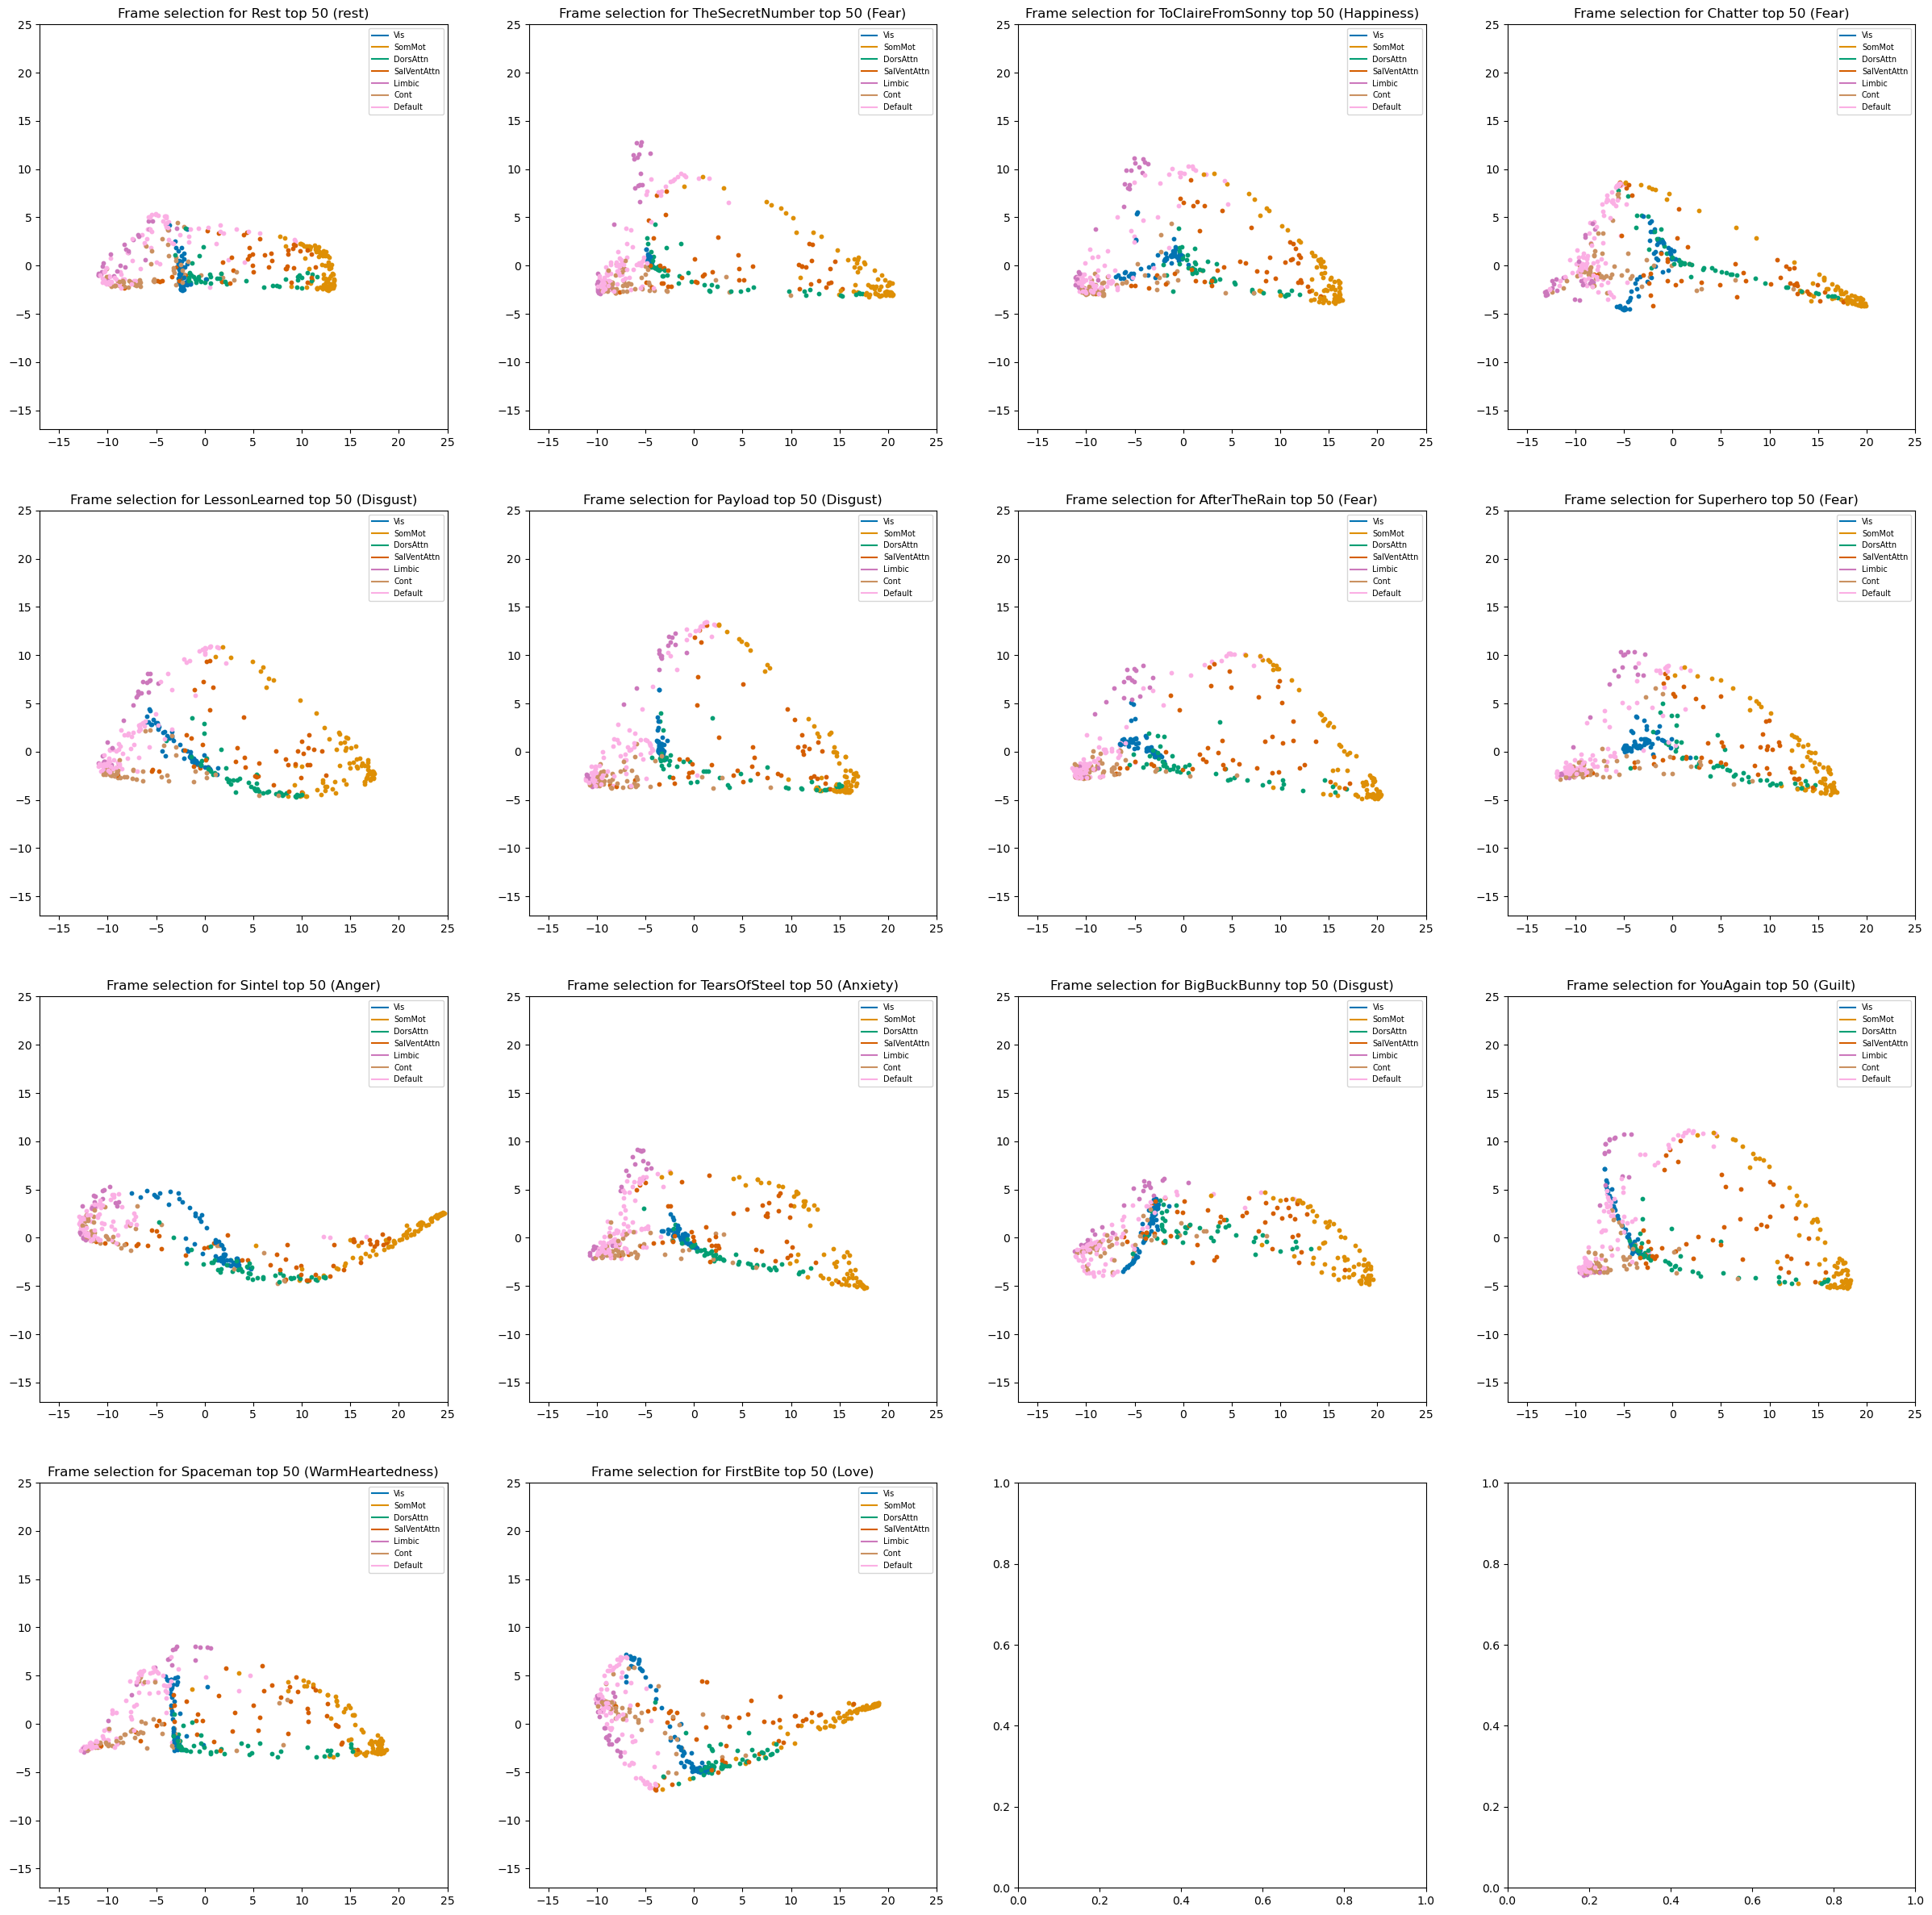

In [99]:
from matplotlib.colors import ListedColormap
pal     = sns.color_palette('colorblind', 8)
my_cmap = ListedColormap(pal)


partial_region = load('./resources/region400yeo7.pkl')
colors = {N: my_cmap.colors[idx] for idx, N in enumerate(list(index2region.keys()))}

fig, axes = plt.subplots(4,4, figsize=(30,30))
for k in range(len(samples_grad)):
    row,col = k//4, k%4

    for i in range(len(samples_grad[k])):
        c   = partial_region[i]
        axes[row,col].scatter([samples_grad[k][i,1]], [samples_grad[k][i,2]], s=10, facecolor=colors[c])

    if samples_label[k] == 'Rest':
        dominant = 'rest'
    else:
        dominant = prop['W_{}13.csv'.format(samples_label[k])][0]
    axes[row,col].set_title("Frame selection for {} top 50 ({})".format(samples_label[k], dominant), size=12)

    C       = list(colors.values())
    labels  = list(colors.keys())
    dummies = [axes[row,col].plot([], [], ls='-', c=c)[0] for c in C]
    axes[row,col].legend(dummies, labels, loc=1, prop={'size':7})
    axes[row,col].set_xlim(-17,25)
    axes[row,col].set_ylim(-17,25)

plt.show()

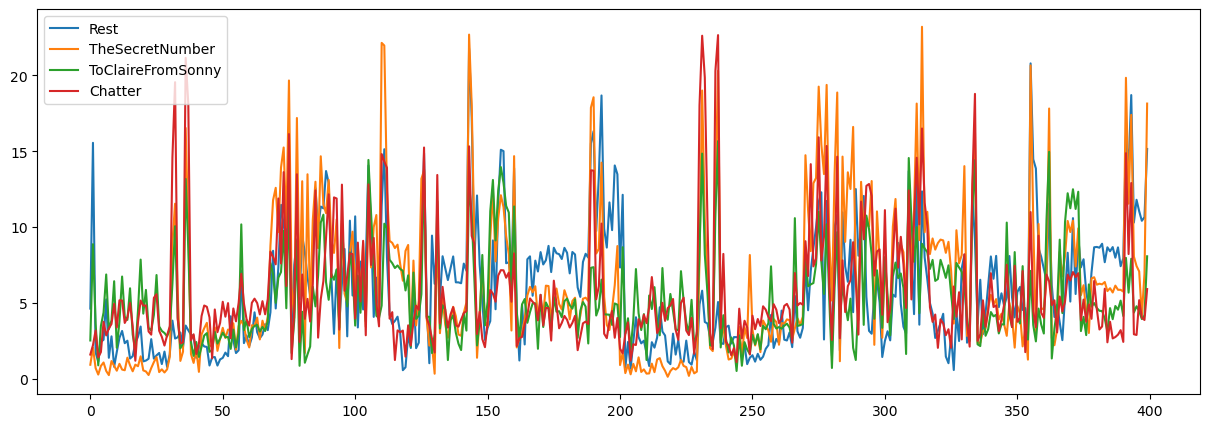

In [97]:
plt.figure(figsize=(15,5))
for k in range(len(samples_grad)-10):
    plt.plot(parcel_to_network(samples_grad[k], type='net_centroid'), label=samples_label[k])

plt.legend()